# Regressão III

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Valores missing e os substitua


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [4]:
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [5]:
df.tempo_emprego.fillna(df.tempo_emprego.mean(), inplace = True)
df.isna().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [6]:
df.index.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [7]:
# Separando base de treino e base de teste
df_treino = df[:'2015-12-01']
df_teste = df['2016-01-01':]

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [8]:
# Reduz o número de variáveis explicativas utilizando a regressão LASSO
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_treino)

# Resumo
res = smf.ols(X1, data=df_treino).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)

resumo = res.summary()
print(f'R-quadrado ajustado: {res.rsquared_adj:.2%}')
resumo.tables[0]

R-quadrado ajustado: 42.37%


Dep. Variable:,np.log(renda),R-squared:,0.424
Model:,OLS,Adj. R-squared:,0.424
Method:,Least Squares,F-statistic:,8.823e+04
Date:,"Thu, 28 Sep 2023",Prob (F-statistic):,0.00
Time:,15:35:37,Log-Likelihood:,-8.0490e+05
No. Observations:,600000,AIC:,1.610e+06
Df Residuals:,599995,BIC:,1.610e+06
Df Model:,5,,
Covariance Type:,nonrobust,,


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [9]:
# Categoriza com 20 quantis
df_treino['tempo_emprego_cat'], quebras = pd.qcut(df_treino.tempo_emprego, 20, duplicates='drop', retbins=True)
print(quebras)
df_treino

[ 0.11780822  0.81643836  1.45753425  2.09589041  2.91232877  3.63561644
  4.29863014  4.93424658  5.75890411  6.62191781  7.47123288  7.7461648
  8.10684932  9.08219178 10.43561644 12.46575342 15.21369863 20.21643836
 42.90684932]


C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\1090076322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treino['tempo_emprego_cat'], quebras = pd.qcut(df_treino.tempo_emprego, 20, duplicates='drop', retbins=True)


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]"
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]"
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]"
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-01,4650,F,N,S,1,Assalariado,Superior incompleto,Solteiro,Casa,37,4.441096,2.0,1893.35,"(4.299, 4.934]"
2015-12-01,9717,M,S,S,0,Empresário,Médio,Casado,Estúdio,44,2.345205,2.0,3080.48,"(2.096, 2.912]"
2015-12-01,7485,M,S,S,0,Assalariado,Médio,Casado,Casa,28,0.736986,2.0,5131.20,"(0.11699999999999999, 0.816]"


In [10]:
perfil = pd.DataFrame()

# Quantidade de observações de cada categoria
perfil['qtd_obs'] = df_treino['tempo_emprego_cat'].value_counts()


# Média do log-renda para cada categoria
df_treino['log_renda'] = np.log(df_treino['renda'])

perfil['log_renda_med'] = df_treino.groupby('tempo_emprego_cat')['log_renda'].mean()

# Média do tempo_emprego para cada categoria

perfil['tempo_emprego_med'] = df_treino.groupby('tempo_emprego_cat')['tempo_emprego'].mean()

perfil.sort_index(inplace=True)
perfil.reset_index(inplace=True)
perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)

perfil

C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\3892129504.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treino['log_renda'] = np.log(df_treino['renda'])


,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.11699999999999999, 0.816]",30234,8.364965,0.515042
1,"(0.816, 1.458]",30031,8.454323,1.125014
2,"(1.458, 2.096]",29736,8.569544,1.781261
3,"(2.096, 2.912]",30013,8.624148,2.510920
4,"(2.912, 3.636]",30408,8.755365,3.301180
5,"(3.636, 4.299]",29625,8.855078,3.987156
6,"(4.299, 4.934]",30109,8.903273,4.610421
7,"(4.934, 5.759]",29991,9.049495,5.367829
8,"(5.759, 6.622]",30003,9.139216,6.205546
9,"(6.622, 7.471]",29926,9.224298,7.009358


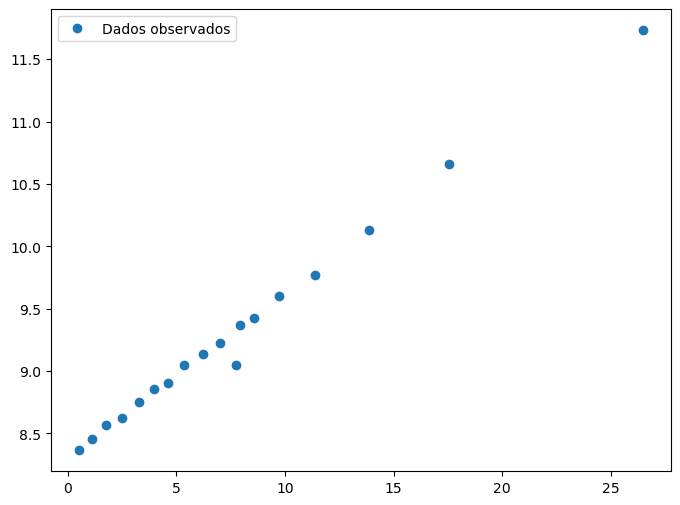

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perfil.tempo_emprego_med, perfil.log_renda_med, "o", label="Dados observados", alpha=1)
ax.legend()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


### - Categorização

In [12]:
df_treino2 = df_treino.merge(perfil, on='tempo_emprego_cat', how='left')
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_cat 
                    + 1''', df_treino2)

res_cat = smf.ols(X2, data=df_treino2).fit()
print(f'R-quadrado ajustado: {res_cat.rsquared_adj:.2%}')

R-quadrado ajustado: 41.93%


### - Transformações sobre X

In [13]:
#logaritimo
res_log = smf.ols(X1,data=df_treino).fit()
print(f'R-quadrado com log: {res_log.rsquared:.2%}')

# exp2
X3 = patsy.dmatrices('''renda**2 ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_treino)

res4 = smf.ols(X3,data=df_treino).fit()
print(f'R-quadrado com exp2: {res4.rsquared:.2%}')

R-quadrado com log: 43.78%
R-quadrado com exp2: 24.50%


### - Lowess

In [14]:
# Suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_treino2.log_renda, df_treino2.tempo_emprego, frac=2/3)

lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_treino2['tempo_emprego_lowess'] = f(df_treino2.tempo_emprego)
df_treino2.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med,tempo_emprego_lowess
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]",9.318131,29999,10.657687,17.538365,10.526933
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]",7.793508,30005,9.599298,9.741024,9.495954
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]",9.528769,29740,9.428302,8.572256,9.290507
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]",7.767196,30031,8.454323,1.125014,8.484386
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]",6.673020,30031,8.454323,1.125014,8.478176


In [15]:
X4 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_treino2)

res_low = smf.ols(X4, data=df_treino2).fit()
print(f'R-quadrado ajustado: {res_low.rsquared_adj:.2%}')

R-quadrado ajustado: 42.60%


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [16]:
# Regressão inicial
df_teste['log_renda']=np.log(df_teste['renda'])

df_teste['pred_inicial'] = res.predict(df_teste)

r = df_teste[['pred_inicial', 'log_renda']].corr().iloc[0,1]
r**2

C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\1111925518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['log_renda']=np.log(df_teste['renda'])
C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\1111925518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['pred_inicial'] = res.predict(df_teste)


0.5294846659497583

In [23]:
#logaritimo
df_teste['pred_log'] = res_log.predict(df_teste)

r = df_teste[['pred_log', 'log_renda']].corr().iloc[0,1]
r**2

C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\870425822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['pred_log'] = res_log.predict(df_teste)


0.5477988066900116

In [21]:
# Suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_teste.log_renda, df_teste.tempo_emprego, frac=2/3)

lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_teste['tempo_emprego_lowess'] = f(df_teste.tempo_emprego)
df_teste['pred_low'] = res_low.predict(df_teste)
r2_score(df_teste.log_renda, df_teste.pred_low)

C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\2246274917.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['tempo_emprego_lowess'] = f(df_teste.tempo_emprego)
C:\Users\arsnf\AppData\Local\Temp\ipykernel_12784\2246274917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['pred_low'] = res_low.predict(df_teste)


0.5324266343305948

Na base teste a regressão utilizando o logaritmo obteve o maior valor de R² em comparação com as outras abordagens utilizadas.